# Programming Assignment 2B
By John Lindblad and Olle Lindgren

## Exercise question

In [22]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline

X1 = [{'city':'Gothenburg', 'month':'July'},
      {'city':'Gothenburg', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y1 = ['rain', 'rain', 'sun', 'rain']

X2 = [{'city':'Sydney', 'month':'July'},
      {'city':'Sydney', 'month':'December'},
      {'city':'Paris', 'month':'July'},
      {'city':'Paris', 'month':'December'}]
Y2 = ['rain', 'sun', 'sun', 'rain']

classifier1 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
classifier1.fit(X1, Y1)
guesses1 = classifier1.predict(X1)
print(accuracy_score(Y1, guesses1))

classifier2 = make_pipeline(DictVectorizer(), Perceptron(max_iter=10))
#classifier2 = make_pipeline(DictVectorizer(), LinearSVC())
classifier2.fit(X2, Y2)
guesses2 = classifier2.predict(X2)
print(accuracy_score(Y2, guesses2))


1.0
0.5


The reason why it can't "memorize" the training data in the second case is beacause the data is not linearly separable.

## Tasks from Pegasos paper

In [23]:
import numpy as np
from sklearn.base import BaseEstimator

import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC

from aml_perceptron import Perceptron, SparsePerceptron

### Implementing the SVC

#### Test-running the given code

In [24]:
# This function reads the corpus, returns a list of documents, and a list
# of their corresponding polarity labels. 
def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y

# Read all the documents.
X, Y = read_data('data/all_sentiment_shuffled.txt')

# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                random_state=0)

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),

    # NB that this is our Perceptron, not sklearn.linear_model.Perceptron
    Perceptron()  
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Training time: 1.92 sec.
Accuracy: 0.7919.


#### Implement the Pegasos algorithm on an SVC

In [25]:
from aml_perceptron import LinearClassifier

In [46]:
class PegasosSVC(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20, lam=0.5):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lam = lam

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t=0

        # Pegasos algorithm:
        for i in range(self.n_iter):
            for x, y in zip(X, Ye):
                
                #computing the new learning rate
                t = t+1
                eta = 1/(self.lam*t)

                # Compute the output score for this instance.
                score = x.dot(self.w)

                # Update the weights
                if y*score < 1:
                    self.w = (1-eta*self.lam)*self.w + (eta*y)*x
                else:
                    self.w = (1-eta*self.lam)*self.w


In [47]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),

    PegasosSVC(lam=1/len(Xtrain), n_iter=100)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Training time: 8.39 sec.
Accuracy: 0.8368.


#### Implementing the Pegasos algorithm with Logistic regression

In [48]:
class PegasosLogisticRegression(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20, lam=0.5):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lam = lam

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t=0

        # Pegasos algorithm:
        for i in range(self.n_iter):
            for x, y in zip(X, Ye):
                
                #computing the new learning rate
                t = t+1
                eta = 1/(self.lam*t)

                # Compute the output score for this instance.
                score = x.dot(self.w)                    
                    
                # Update the weights
                self.w = (1-eta*self.lam)*self.w + eta*(y/(1+np.exp(y*score)))*x

In [49]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),

    PegasosLogisticRegression(lam=1/len(Xtrain), n_iter=100)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Training time: 12.70 sec.
Accuracy: 0.8380.


## Bonus tasks

### Bonus task 3: Additional loss functions

In [ ]:
class PegasosSVC_smoothedHinge(LinearClassifier):
    """
    A straightforward implementation of the perceptron learning algorithm.
    """

    def __init__(self, n_iter=20, lam=0.5):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lam = lam

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """
    
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t=0

        # Pegasos algorithm:
        for i in range(self.n_iter):
            for x, y in zip(X, Ye):
                
                #computing the new learning rate
                t = t+1
                eta = 1/(self.lam*t)

                # Compute the output score for this instance.
                score = x.dot(self.w)
                
                # Update the weights
                if y*score <= 0:
                    self.w += eta
                elif (y*score > 0) and (y*score < 1):
                    self.w -= (y*score-1)*eta

In [ ]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),

    PegasosSVC_smoothedHinge(lam=1/len(Xtrain), n_iter=100)
    #PegasosSVC_smoothedHinge(lam=0.1, n_iter=100)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

# Bonus task 1
By John Lindblad and Olle Lindgren

The classifiers are located in the accompanying file linear_classifiers.py

## Initial setup

In [52]:
import numpy as np
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# This function reads the corpus, returns a list of documents, and a list
# of their corresponding polarity labels. 
def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y

# Read all the documents.
X, Y = read_data('data/all_sentiment_shuffled.txt')

# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2,
                                                random_state=0)

# Bonus 1: Optimization

There are two classes, Pegasos_BLAS and Pegasos_Sparse.

Steps a and c are in BLAS while b and c are in Sparse.

### Sparse

In [53]:
from scipy.sparse import csr_matrix
from aml_perceptron import LinearClassifier
class Pegasos_Sparse(LinearClassifier):
    '''
    Our linear classifier implementation, made for using sparse matrices.
    Since the BLAS functions don't work with the sparse matrices from scipy, we wrote this separately.
    We're postponing scaling self.w in both of them, since that's pretty separate.
    '''

    def __init__(self, n_iter=20, lam=0.5, type='SVC'):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.lam = lam
        if type=='SVC':
            self.update_weights = self.update_weights_SVC
        elif type=='LR':
            self.update_weights = self.update_weights_LR

    @classmethod
    def add_sparse_to_dense(cls, x, w, factor):
        """
        Adds a sparse vector x, scaled by some factor, to a dense vector.
        This can be seen as the equivalent of w += factor * x when x is a dense
        vector.
        """
        w[x.indices] += factor * x.data

    @classmethod
    def sparse_dense_dot(cls, x, w):
        """
        Computes the dot product between a sparse vector x and a dense vector w.
        """
        return np.dot(w[x.indices], x.data)
    
    def update_weights_SVC(self, eta, x, w, y, score, a):
        if y*score < 1:
            self.add_sparse_to_dense(x, w, factor=eta*y/a)
    
    def update_weights_LR(self, eta, x, w, y, score, a):
        self.add_sparse_to_dense(x, w, factor=eta*(y/(1+np.exp(y*score)))/a)
    
    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        assert isinstance(X, csr_matrix)

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t=0
        a=1
        # Pegasos algorithm:
        for _ in range(self.n_iter):
            for x, y in zip(X, Ye):
                # Compute the new learning rate
                t = t+1
                eta = 1/(self.lam*t)

                # Compute the output score for this instance
                score = a*self.sparse_dense_dot(x, self.w)

                # Scale a
                a *= (1-eta*self.lam)

                # Update the weights
                self.update_weights(eta, x, self.w, y, score, a)
                    
            # Catch up on scaling w, reset a
            dscal(a, self.w)
            a=1

### BLAS

In [54]:
from scipy.linalg.blas import ddot, dscal, daxpy
from aml_perceptron import LinearClassifier
class Pegasos_BLAS(LinearClassifier):
    '''
    Our linear classifier implementation, using the BLAS functions. 
    We're also postponing scaling self.w.
    It's mostly copy/paste from the reference code.
    '''

    def __init__(self, n_iter=20, lam=0.5, type='SVC'):
        """
        The constructor takes a type parameter, which can be either SVC or LR. 
        This only affects the loss function.
        """
        self.n_iter = n_iter
        self.lam = lam
        if type=='SVC':
            self.update_weights = self.update_weights_SVC
        elif type=='LR':
            self.update_weights = self.update_weights_LR
    
    def update_weights_SVC(self, eta, x, w, y, score, a):
        if y*score < 1:
            daxpy(x, w, a=eta*y/a)
    
    def update_weights_LR(self, eta, x, w, y, score, a):
        daxpy(x, w, a=eta*(y/(1+np.exp(y*score)))/a)

    def fit(self, X, Y):
        """
        Train a linear classifier using the perceptron learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        t=0
        a = 1
        # Pegasos algorithm:
        for i in range(self.n_iter):
            for x, y in zip(X, Ye):
                # Compute the new learning rate
                t = t+1
                eta = 1/(self.lam*t)

                # Compute the output score for this instance
                score = a*ddot(x, self.w)

                # Scale a
                a *= (1-eta*self.lam)

                # Update the weights
                self.update_weights(eta, x, self.w, y, score, a)
            
            # Catch up on scaling w, reset a
            dscal(a, self.w)
            a=1

## A couple of test runs

## Sparse, LR

In [55]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(), # adding the ngram parameter makes it very slow
    SelectKBest(k=1000), # removing this also makes it slow. I'm not paitent enough.
    Normalizer(),

    Pegasos_Sparse(lam=1/len(Xtrain), n_iter=15, type='LR')
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Training time: 9.04 sec.
Accuracy: 0.8338.


## BLAS, SVC

BLAS is a bit quicker.

In [56]:
# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),

    Pegasos_BLAS(lam=1/len(Xtrain), n_iter=15, type='SVC')
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Training time: 1.82 sec.
Accuracy: 0.8347.


## Some results
### SVC

My laptop has a lot of features that make these comparisons difficult, like thermal throttling, low power modes and such. Don't take too seriously.

The (c) part, postponing the scaling of w, is added to both the BLAS and Sparse implementations.

#### Unoptimized
Training time: 13.03 sec.
Accuracy: 0.8380.

#### BLAS
Training time: 5.83 sec.
Accuracy: 0.8368.

#### Without SelectKBest
Training time: 121.57 sec.
Accuracy: 0.8418.

#### ngram_range=(1,2)
Crash: unable to allocate 34.1GB array.

#### Sparse vectors, original pipeline
Training time: 47.77 sec.
Accuracy: 0.8368.

### LR

#### Unoptimized
Training time: 12.41 sec.
Accuracy: 0.8380.

#### BLAS
Training time: 9.39 sec.
Accuracy: 0.8384.

#### With blas and scaling a
Training time: 5.59 sec.
Accuracy: 0.8368.

#### Without SelectKBest
Training time: 121.57 sec.
Accuracy: 0.8418.

#### ngram_range=(1,2)
Crash: unable to allocate 34.1GB array.

#### Sparse vectors, original pipeline
Training time: 53.08 sec.
Accuracy: 0.8368.

# Bonus 4: PyTorch

Like the Sparse and BLAS classifiers above, the SVC and LR implementations both share the same class.

In [57]:
import numpy as np
import torch

class Torch_Classifier:
    '''
    Like the Pegasos classifiers, we're using the same class for both SVC and LR. 
    Change between them by passing type='SVC' or type='LR' to the constructor.
    '''
    def __init__(
        self, 
        n_iter=15, 
        eta=0.1, 
        batch_size=10, 
        opt=None, 
        type='SVC', 
        use_cuda=False, 
        verbose=False):
        """
        n_iter:     number of iterations (epochs) to train for
        eta:        The learning rate used for the default Adam optimizer if opt=None
        batch_size: size of batches used.
        opt:        function that initializes an optimizer from torch.optim.
        type:       SVC or LR
        use_cuda:   Whether to use cuda. Ignored if CUDA is not available.
        verbose:    Whether to print the loss every iteration.
        """
        self.n_iter = n_iter
        self.eta = eta
        self.batch_size = batch_size
        self.opt = opt
        self.type=type
        self.verbose = verbose
        # Set torch device
        if use_cuda and torch.cuda.is_available():
            self.device = 'cuda'
        else:
            self.device = 'cpu'
        if type != 'SVC' and type != 'LR':
            raise Exception("Unknown classifier type: {}".format(type))

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of
        classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])

    def fit(self, X, Y):
        
        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        X = X.toarray()

        Ye = self.encode_outputs(Y)

        n_instances, n_features = X.shape
        assert X.shape[0] == Ye.shape[0]
        
        # we need to "wrap" the NumPy arrays X and Y as PyTorch tensors
        Xt = torch.tensor(X, dtype=torch.float, device=self.device)
        Yt = torch.tensor(Ye, dtype=torch.float, device=self.device)

        # initialize the weight vector to all zeros
        self.w = torch.zeros(n_features, requires_grad=True, dtype=torch.float, device=self.device)
        self.history = []

        if self.opt is None:
            optimizer = torch.optim.Adam([self.w], lr=self.eta)
        else:
            optimizer = self.opt(self.w)

        tol = 1e-5
        iteration = 0
        
        converged = False
        # While not enough iterations or not converged
        while iteration < self.n_iter and not converged:
            iteration += 1
            total_loss = 0
            
            for batch_start in range(0, n_instances, self.batch_size):
                batch_end = batch_start + self.batch_size

                # pick out the batch again, as in the other notebook
                Xbatch = Xt[batch_start:batch_end, :]
                Ybatch = Yt[batch_start:batch_end]
            
                # mv = matrix-vector multiplication in Torch
                G = Xbatch.mv(self.w)
                score = Ybatch*G

                if self.type=='SVC':
                    # Calculate hinge loss
                    loss_batch = torch.sum(1-score[score<1]) / n_instances
                elif self.type=='LR':
                    # Calculate log loss
                    loss_batch = torch.sum(torch.log(1+torch.exp(-score))) / n_instances
                    
                # we sum up the loss values for all the batches.
                # the item() here is to convert the tensor into a single number
                total_loss += loss_batch.item()
                
                # reset all gradients
                optimizer.zero_grad()                  

                # compute the gradients for the loss for this batch
                loss_batch.backward()

                # for SGD, this is equivalent to w -= learning_rate * gradient as we saw before
                optimizer.step()

            self.history.append(total_loss)

            # Determine if converged
            if iteration >= 2:
                converged = self.history[len(self.history)-2] - self.history[len(self.history)-1] < tol
            
            if self.verbose:
                print(f"Iteration: {iteration:3.0f}, loss: {total_loss:9.6f}")
        print('Minibatch final loss: {:.4f}'.format(total_loss))
    
    def predict(self, X):
        '''
        We know, we weren't supposed to care about the accuracy but we just couldn't resist.
        By the way, it overfits.
        '''
        Xt = torch.tensor(X.toarray(), dtype=torch.float, device=self.device)
        pred = Xt.mv(self.w)
        result = [self.positive_class if p > 0 else self.negative_class for p in pred]
        return result


## Optimizers

We could have gotten the loss down further by just adding more iterations. After 15, it's pretty close though and looking at the accuracy it doesn't really get better with more for most of the optimizers.

## Adam

Since Adam is so famous, let's do Adam first.

Minibatch final loss: 0.2887
Training time: 4.61 sec.
Accuracy: 0.8112.


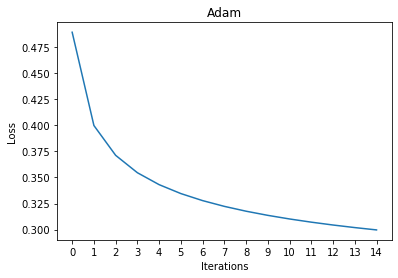

In [58]:
# Set up the preprocessing steps and the classifier.
def opt(w):
    return torch.optim.Adam([w], lr=.05)
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    Torch_Classifier(opt=opt, type='SVC', n_iter=15)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

import matplotlib.pyplot as plt
plt.plot(tc.history)
plt.title("Adam")
plt.xlabel("Iterations")
plt.xticks(range(0, len(tc.history)), range(0, len(tc.history)))
plt.ylabel("Loss")
plt.show()

## Results: Adam

### LR
Minibatch final loss: 0.2424
Training time: 5.97 sec.
Accuracy: 0.8326.

### SVC
Minibatch final loss: 0.2462
Training time: 5.95 sec.
Accuracy: 0.8288.

## SGD

Minibatch final loss: 0.4716
Training time: 5.17 sec.
Accuracy: 0.7940.


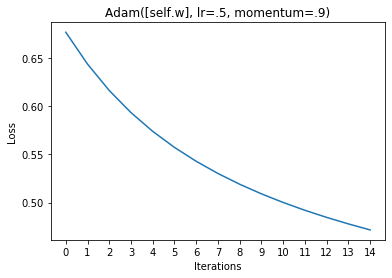

In [59]:
# Set up the preprocessing steps and the classifier.
def opt(w):
    return torch.optim.SGD([w], lr=.98, momentum=.98)
tc = Torch_Classifier(opt=opt, type='LR', n_iter=15)
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    tc
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

import matplotlib.pyplot as plt
plt.plot(tc.history)
plt.title("Adam([self.w], lr=.5, momentum=.9)")
plt.xlabel("Iterations")
plt.xticks(range(0, len(tc.history)), range(0, len(tc.history)))
plt.ylabel("Loss")
plt.show()

## Results: SGD

### SVC
Minibatch final loss: 0.4099
Training time: 6.01 sec.
Accuracy: 0.8175.

### LR
Minibatch final loss: 0.4716
Training time: 5.52 sec.
Accuracy: 0.7940.

## RMSProp

Minibatch final loss: 0.2680
Training time: 5.52 sec.
Accuracy: 0.8389.


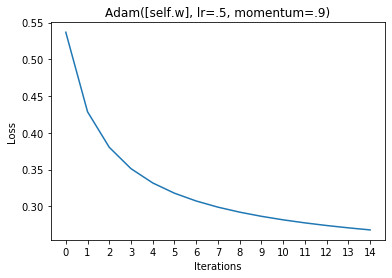

In [60]:
# Set up the preprocessing steps and the classifier.
def opt(w):
    return torch.optim.RMSprop([w], lr=.003, alpha=.997, weight_decay=0, momentum=0)
tc = Torch_Classifier(opt=opt, type='LR', n_iter=15)
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    tc
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

import matplotlib.pyplot as plt
plt.plot(tc.history)
plt.title("Adam([self.w], lr=.5, momentum=.9)")
plt.xlabel("Iterations")
plt.xticks(range(0, len(tc.history)), range(0, len(tc.history)))
plt.ylabel("Loss")
plt.show()

## Results: RMSProp

### SVC
Minibatch final loss: 0.2668
Training time: 5.62 sec.
Accuracy: 0.8355.

### LR
Minibatch final loss: 0.2680
Training time: 4.91 sec.
Accuracy: 0.8389.

## Optimizer: Adagrad

Minibatch final loss: 0.2997
Training time: 5.51 sec.
Accuracy: 0.8405.


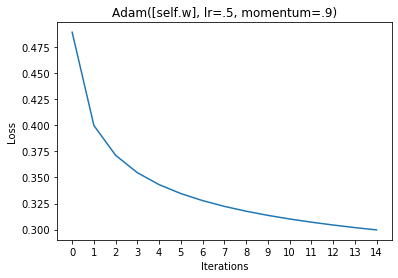

In [61]:
# Set up the preprocessing steps and the classifier.
def opt(w):
    return torch.optim.Adagrad([w], lr=.1, lr_decay=0, weight_decay=0, initial_accumulator_value=0)
tc = Torch_Classifier(opt=opt, type='LR', n_iter=15)
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    tc
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

import matplotlib.pyplot as plt
plt.plot(tc.history)
plt.title("Adam([self.w], lr=.5, momentum=.9)")
plt.xlabel("Iterations")
plt.xticks(range(0, len(tc.history)), range(0, len(tc.history)))
plt.ylabel("Loss")
plt.show()

## Results: Adagrad

### SVC
Minibatch final loss: 0.2918
Training time: 5.59 sec.
Accuracy: 0.8397.

### LR
Minibatch final loss: 0.2997
Training time: 5.13 sec.
Accuracy: 0.8405.